In [36]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
fires = pd.read_sql_query('select * from Fires', conn)

In [74]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880465 entries, 0 to 1880464
Data columns (total 39 columns):
OBJECTID                      int64
FOD_ID                        int64
FPA_ID                        object
SOURCE_SYSTEM_TYPE            object
SOURCE_SYSTEM                 object
NWCG_REPORTING_AGENCY         object
NWCG_REPORTING_UNIT_ID        object
NWCG_REPORTING_UNIT_NAME      object
SOURCE_REPORTING_UNIT         object
SOURCE_REPORTING_UNIT_NAME    object
LOCAL_FIRE_REPORT_ID          object
LOCAL_INCIDENT_ID             object
FIRE_CODE                     object
FIRE_NAME                     object
ICS_209_INCIDENT_NUMBER       object
ICS_209_NAME                  object
MTBS_ID                       object
MTBS_FIRE_NAME                object
COMPLEX_NAME                  object
FIRE_YEAR                     int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                 int64
DISCOVERY_TIME                object
STAT_CAUSE_CODE               float64
S

## Sample 10% of the dataset and begin the exploration
There are 1880645 rows in the full dataset, which makes running algorithms very costly during the development stage. The full dataset can be used again when the algorithms are finalized.

In [56]:
fires_sample = fires.sample(frac=1/10, random_state=1)
fires_sample.sample(10)

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
662926,662927,725175,SFO-VA0266-BRU001621,NONFED,ST-NASF,ST/C&L,USVAVAS,Virginia Department of Forestry,VAVAS,Virginia Department of Forestry,None,None,None,None,None,None,None,None,None,2007,2454196.5,96,None,2.0,Equipment Use,NaN,NaN,None,0.5,B,36.905560,-77.906390,14.0,MISSING/NOT SPECIFIED,VA,Brunswick,025,Brunswick,b'\x00\x01\xad\x10\x00\x00\xf8\xda3K\x02zS\xc0...
1445677,1445678,19968240,WI-62060362002,NONFED,ST-WIWIS,ST/C&L,USWIWIS,Wisconsin Department of Natural Resources,Dispatch Group 62,Wisconsin Rapids District,None,36,None,None,None,None,None,None,None,2002,2452379.5,105,None,6.0,Railroad,NaN,NaN,None,0.7,B,44.412247,-89.226226,14.0,MISSING/NOT SPECIFIED,WI,50,097,Portage,b'\x00\x01\xad\x10\x00\x00L\xe0\x9d|zNV\xc0\xe...
976452,976453,1105083,TFS_FL_59404,NONFED,ST-FLFLS,ST/C&L,USFLFLS,Florida Forest Service,FLFLS17,FLS Caloosahatchee Forestry Center,None,0385,None,None,None,None,None,None,None,1996,2450399.5,317,None,2.0,Equipment Use,NaN,NaN,None,200.0,D,26.000000,-81.470000,14.0,MISSING/NOT SPECIFIED,FL,Collier,021,Collier,b'\x00\x01\xad\x10\x00\x00\xacG\xe1z\x14^T\xc0...
1428394,1428395,19507259,NCST-063-20100081,NONFED,ST-NCNCS,ST/C&L,USNCNCS,North Carolina Forest Service,NCNCS,North Carolina Division of Forest Resources,None,None,None,OVERLOOK FIRE,None,None,None,None,None,2010,2455247.5,51,1300,5.0,Debris Burning,2455247.5,51.0,1345,0.1,A,35.385767,-79.562867,8.0,PRIVATE,NC,Moore,125,Moore,b'\x00\x01\xad\x10\x00\x00X-\xe2\x01\x06\xe4S\...
1488981,1488982,201159240,2011GAGAS-FY2012-Johnson-007,NONFED,ST-NASF,ST/C&L,USGAGAS,Georgia Forestry Commission,GAGAS,Georgia Forestry Commission,None,FY2012-Johnson-007,None,FY2012-JOHNSON-007,None,None,None,None,None,2011,2455796.5,235,1345,1.0,Lightning,2455796.5,235.0,1500,4.8,B,32.563875,-82.644205,8.0,PRIVATE,GA,Johnson,167,Johnson,b'\x00\x01\xad\x10\x00\x00<}>\xa9:\xa9T\xc0\xb...
1715330,1715331,201933338,IA-IITF-33338,INTERAGCY,IA-PRIITF,IA,USPRIITF,International Institute of Tropical Forestry,PRIITF,International Institute of Tropical Forestry,None,None,None,None,None,None,None,None,None,2007,2454200.5,100,None,13.0,Missing/Undefined,NaN,NaN,None,2.0,B,18.000149,-66.100899,14.0,MISSING/NOT SPECIFIED,PR,None,None,None,b'\x00\x01\xad\x10\x00\x00\xbcL\x14!u\x86P\xc0...
386985,386986,409916,SFO-AR0394-133_02_021,NONFED,ST-NASF,ST/C&L,USARARS,Arkansas Forestry Commission,ARARS2,ARS District 2,None,None,None,None,None,None,None,None,None,2008,2454674.5,209,None,3.0,Smoking,NaN,NaN,None,8.0,B,34.117710,-94.285000,14.0,MISSING/NOT SPECIFIED,AR,Sevier,133,Sevier,b'\x00\x01\xad\x10\x00\x00\x08\xd7\xa3p=\x92W\...
645024,645025,697154,SFO-TX0482-133177,NONFED,ST-NASF,ST/C&L,USTXTXS,Texas A & M Forest Service,TXTXS,Texas Forest Service,None,None,None,None,None,None,None,None,None,2008,2454537.5,72,None,9.0,Miscellaneous,NaN,NaN,None,0.3,B,30.153730,-97.314560,14.0,MISSING/NOT SPECIFIED,TX,Bastrop,021,Bastrop,"b""\x00\x01\xad\x10\x00\x00L(D\xc0!TX\xc0\x10jj..."
119816,119817,121017,FS-346058,FED,FS-FIRESTAT,FS,USORDEF,Deschutes National Forest,0601,Deschutes National Forest,14,None,0608,0152,None,None,None,None,None,2000,2451690.5,147,1147,9.0,Miscellaneous,2451690.5,147.0,1600,0.1,A,43.676389,-121.521667,6.0,OTHER FEDERAL,OR,None,None,None,b'\x00\x01\xad\x10\x00\x00\x08\xc4\x99\xfcba^\...
370723,370724,382592,FWS-2006FLLWRCNU0,FED,FWS-FMIS,FWS,USFLLWR,Lake Woodruff National Wildlife Refuge,FLLWR,Lake Woodruff National Wildlife Refuge,None,None,CNU0,WOOD D

In [6]:
fires_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 188046 entries, 435781 to 1627117
Data columns (total 39 columns):
OBJECTID                      188046 non-null int64
FOD_ID                        188046 non-null int64
FPA_ID                        188046 non-null object
SOURCE_SYSTEM_TYPE            188046 non-null object
SOURCE_SYSTEM                 188046 non-null object
NWCG_REPORTING_AGENCY         188046 non-null object
NWCG_REPORTING_UNIT_ID        188046 non-null object
NWCG_REPORTING_UNIT_NAME      188046 non-null object
SOURCE_REPORTING_UNIT         188046 non-null object
SOURCE_REPORTING_UNIT_NAME    188046 non-null object
LOCAL_FIRE_REPORT_ID          41924 non-null object
LOCAL_INCIDENT_ID             105876 non-null object
FIRE_CODE                     32542 non-null object
FIRE_NAME                     92343 non-null object
ICS_209_INCIDENT_NUMBER       2543 non-null object
ICS_209_NAME                  2543 non-null object
MTBS_ID                       1073 non-null 

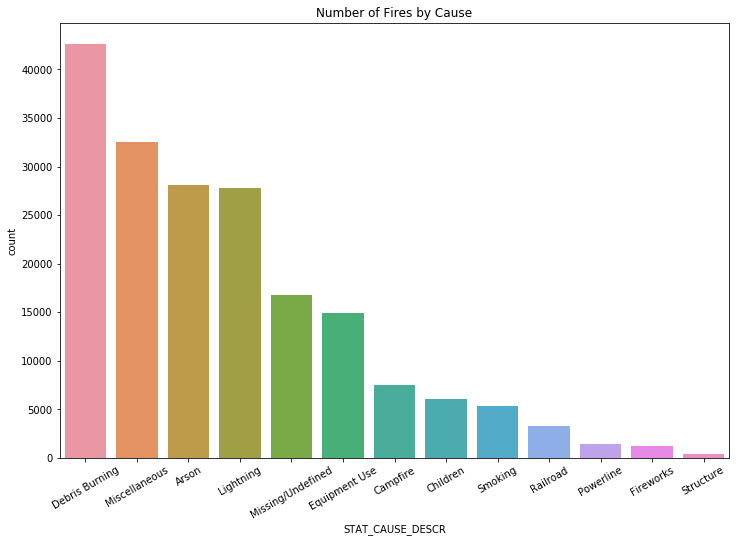

In [8]:
fig = plt.figure(figsize=(12,8))
fire_cause_plot = sns.countplot(x='STAT_CAUSE_DESCR', 
                                data=fires_sample, 
                                order=fires_sample.STAT_CAUSE_DESCR.value_counts().index)
fire_cause_plot.set_title('Number of Fires by Cause')
fire_cause_plot.set_xticklabels(fire_cause_plot.get_xticklabels(), rotation=30);

## Explore fire cause vs. fire size

A=greater than 0 but less than or equal to 0.25 acres<br />
B=0.26-9.9 acres<br />
C=10.0-99.9 acres<br />
D=100-299 acres<br />
E=300 to 999 acres<br />
F=1000 to 4999 acres<br />
G=5000+ acres

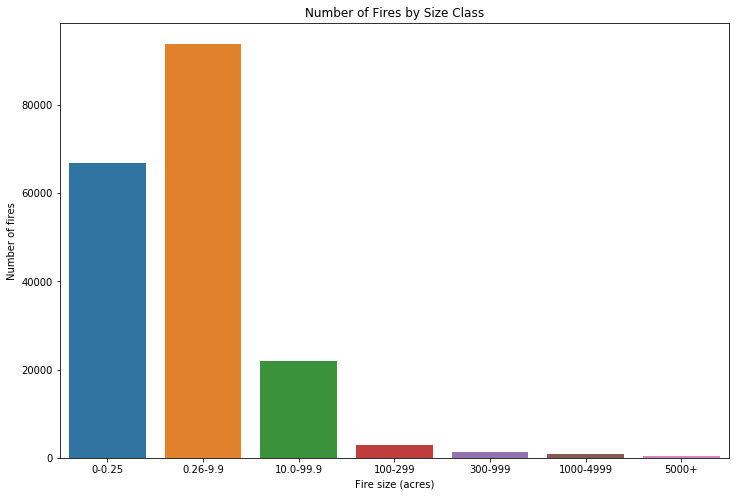

In [7]:
plt.figure(figsize=(12, 8))
fire_size_plot = sns.countplot(x='FIRE_SIZE_CLASS', data=fires_sample, order=['A','B','C','D','E','F','G'])
fire_size_plot.set_title('Number of Fires by Size Class')
fire_size_plot.set_xlabel('Fire size (acres)')
fire_size_plot.set_ylabel('Number of fires')
fire_size_plot.set_xticklabels(['0-0.25', '0.26-9.9', '10.0-99.9', '100-299', '300-999', '1000-4999', '5000+']);

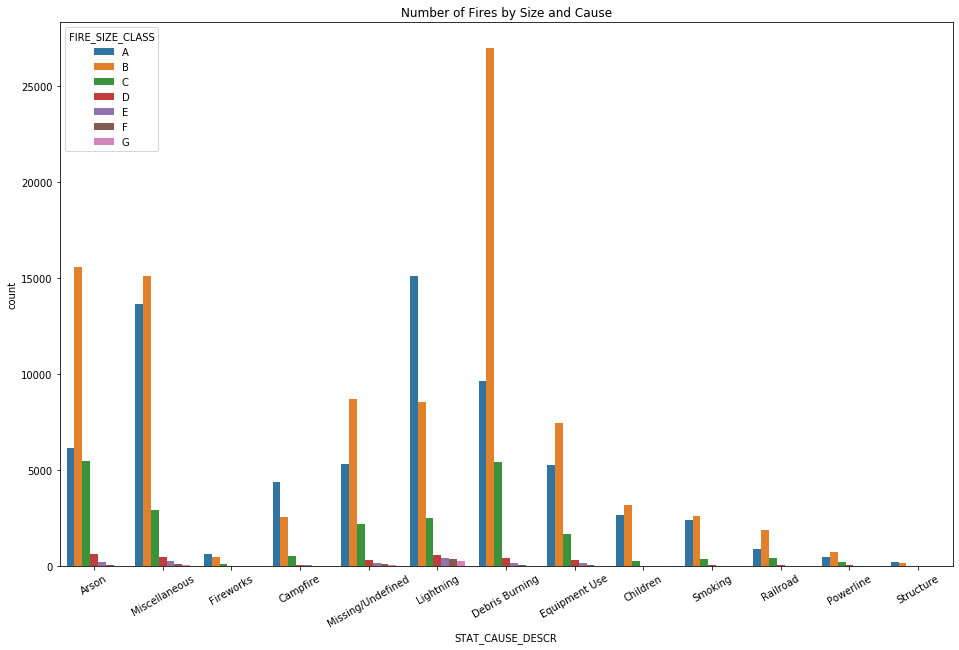

In [9]:
fig = plt.figure(figsize=(16,10))
size_cause_plot = sns.countplot(x='STAT_CAUSE_DESCR',
                                hue='FIRE_SIZE_CLASS',
                                data=fires_sample,
                                hue_order=['A','B','C','D','E','F','G'])
size_cause_plot.set_title('Number of Fires by Size and Cause')
size_cause_plot.set_xticklabels(size_cause_plot.get_xticklabels(), rotation=30);

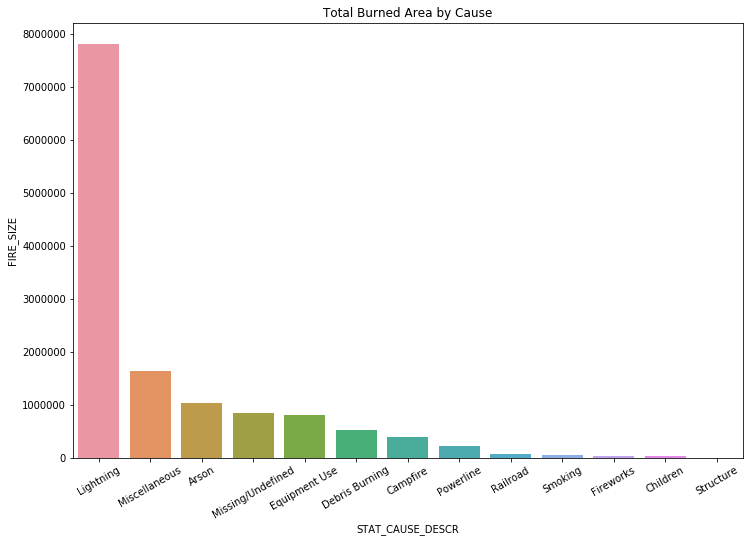

In [10]:
fire_size_by_cause = fires_sample.groupby(['STAT_CAUSE_DESCR'])['FIRE_SIZE'].sum().reset_index()

plt.figure(figsize=(12,8))
fire_size_by_cause_plot = sns.barplot(x='STAT_CAUSE_DESCR', 
                                      y='FIRE_SIZE', 
                                      data=fire_size_by_cause, 
                                      order=fire_size_by_cause.sort_values(by='FIRE_SIZE', ascending=False).STAT_CAUSE_DESCR.tolist())
fire_size_by_cause_plot.set_title('Total Burned Area by Cause')
fire_size_by_cause_plot.set_xticklabels(fire_size_by_cause_plot.get_xticklabels(), rotation=30);

It is shown that the majority of burned area is caused by lightning, which is a natural cause. People may argue that preventing natural fires disturbs the balance of the ecosystem, but as global temperature keeps rising, even natural fires caused by lightning will burn more severely. It is a complicated to figure out whether it is a good idea to mitigate fires no matter the cause, but for the purpose of analyzing wildfires, we will keep going.

## Explore other features

### Latitude and longitude

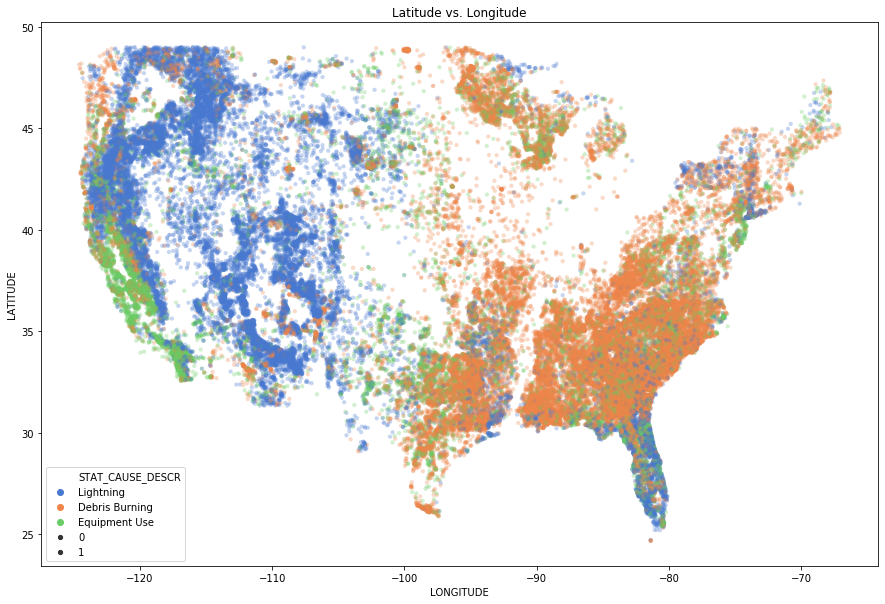

In [152]:
plt.figure(figsize=(15,10))
lat_lon_plot = sns.scatterplot(x='LONGITUDE',
                               y='LATITUDE',
                               data=fires[(fires['LONGITUDE']>-127) & 
                                          (fires['LONGITUDE']<-60) & 
                                          (fires['LATITUDE']<50) &
                                          (fires['LATITUDE']>22) &
                                          ((fires['STAT_CAUSE_DESCR']=='Lightning') |
                                           (fires['STAT_CAUSE_DESCR']=='Debris Burning') |
                                           (fires['STAT_CAUSE_DESCR']=='Equipment Use'))
                                         ].sample(80000),
                               hue='STAT_CAUSE_DESCR',
                               alpha=0.3,
                               size=1,
                               linewidth=0,
                               palette='muted')
lat_lon_plot.set_title('Latitude vs. Longitude');

### Fire year

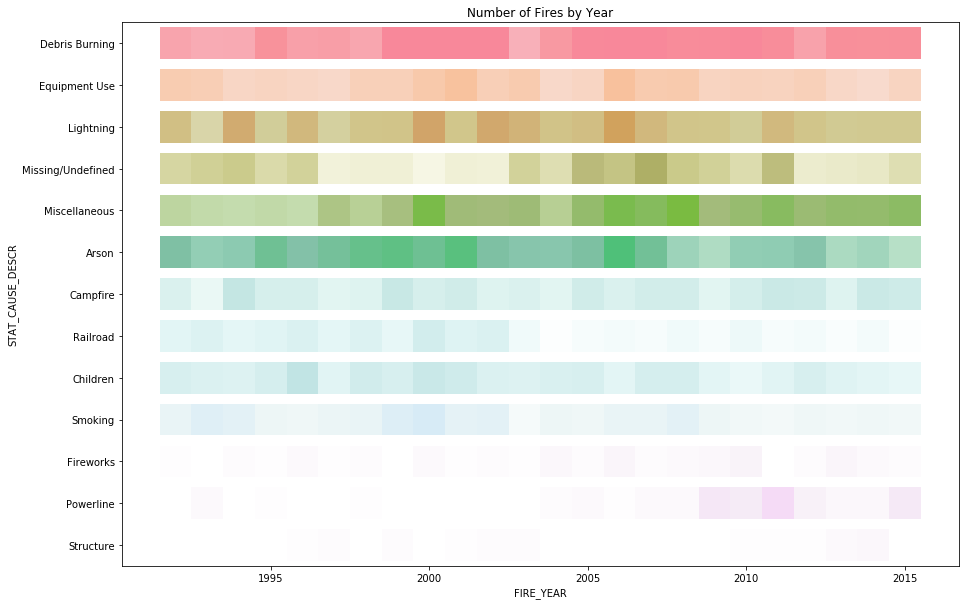

In [11]:
plt.figure(figsize=(15,10))
fire_by_year_plot = sns.stripplot(x='FIRE_YEAR', 
                                  y='STAT_CAUSE_DESCR', 
                                  data=fires.sample(10000), 
                                  size=31.7, 
                                  marker='s', 
                                  alpha=0.01,
                                  jitter=False)
fire_by_year_plot.set_title('Number of Fires by Year');

### Fire discovery day of year

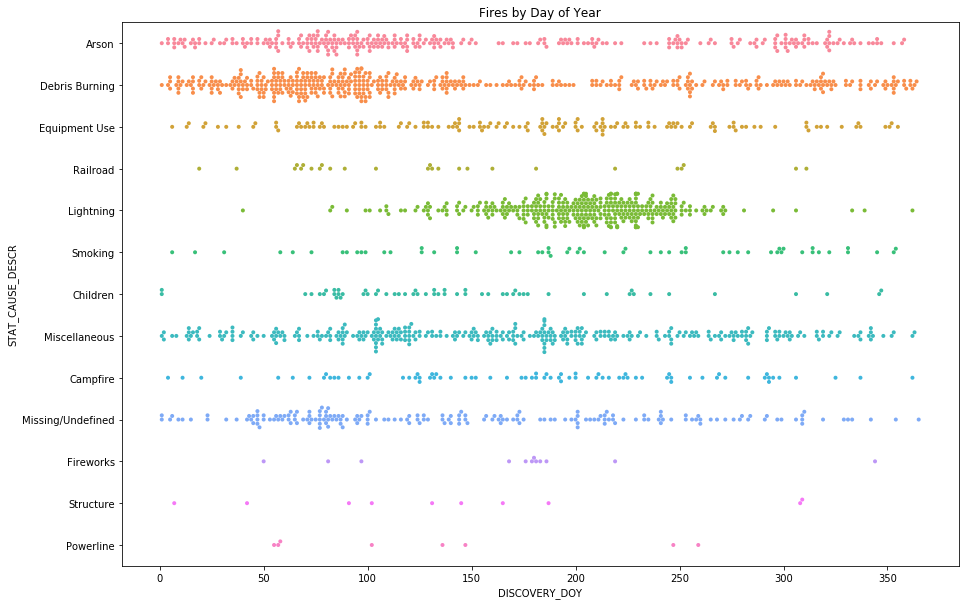

In [12]:
plt.figure(figsize=(15,10))
doy_cause_plot = sns.swarmplot(x='DISCOVERY_DOY', y='STAT_CAUSE_DESCR', data=fires.sample(2000), size=4)
doy_cause_plot.set_title('Fires by Day of Year');

### Fire discovery time of day

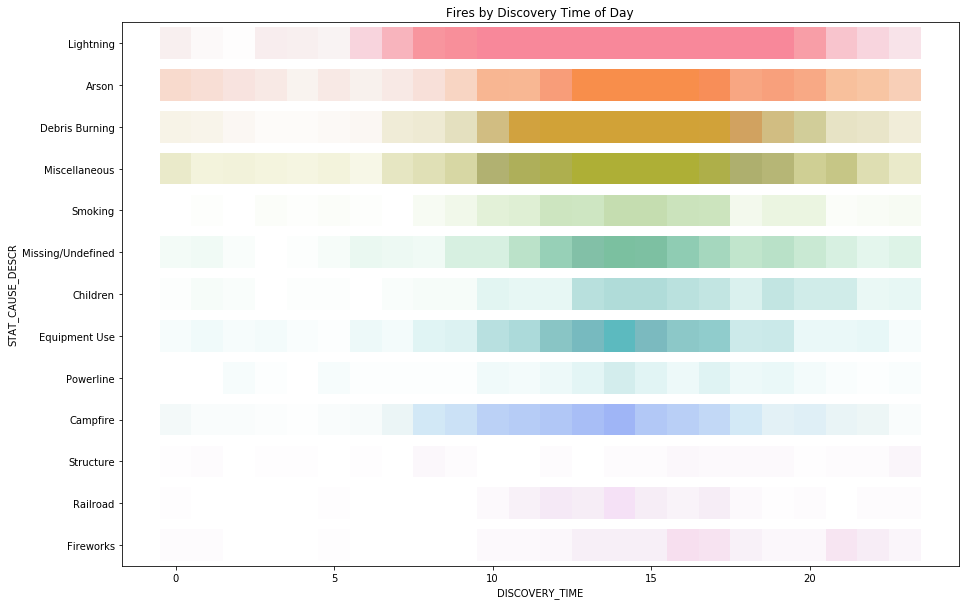

In [67]:
# drop missing DISCOVERY_TIME
fires_sample_with_time = fires_sample.dropna(subset=['DISCOVERY_TIME']).copy()
fires_sample_with_time['DISCOVERY_TIME'] = fires_sample_with_time['DISCOVERY_TIME'].astype(str).str[:2].astype(int)

plt.figure(figsize=(15,10))
time_cause_plot = sns.stripplot(x='DISCOVERY_TIME',
                                y='STAT_CAUSE_DESCR',
                                data=fires_sample_with_time.sample(10000), 
                                size=31.7, 
                                marker='s',
                                alpha=0.01,
                                jitter=False)
time_cause_plot.set_title('Fires by Discovery Time of Day');

The graph shows the relationship between fire discovery time of day and fire cause. DISCOVERY_TIME can be a helpful feature, however, there is too much missing data for the DISCOVERY_TIME column. If I only choose to use columns where DISCOVERY_TIME is not null, the rest of the data will be represented inaccurately. Maybe those where DISCOVERY_TIME is missing tend to be larger fires caused by lightning in remote areas.

## Select features

In [68]:
features = ['FIRE_YEAR', 'FIRE_SIZE', 'DISCOVERY_DOY', 'LATITUDE', 'LONGITUDE']
X = fires_sample[features]
y = fires_sample['STAT_CAUSE_DESCR']

train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=1)

## Preliminary assessment of machine learning algorithms

In [64]:
# Decision tree
dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(train_X, train_y)
dt_prediction = dt_model.predict(val_X)

print('Decision tree accuracy:', metrics.accuracy_score(val_y, dt_prediction))


# Random forest
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(train_X, train_y)
rf_prediction = rf_model.predict(val_X)

print('Random forest accuracy:', metrics.accuracy_score(val_y, rf_prediction))


# Gradient boosting
gb_model = GradientBoostingClassifier(random_state=1)
gb_model.fit(train_X, train_y)
gb_prediction = gb_model.predict(val_X)

print('Gradient boosting accuracy:', metrics.accuracy_score(val_y, gb_prediction))


# XGBoost
xgb_model = XGBClassifier(random_state=1)
xgb_model.fit(train_X, train_y)
xgb_prediction = xgb_model.predict(val_X)

print('XGBoost accuracy:', metrics.accuracy_score(val_y, xgb_prediction))


# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(train_X, train_y)
knn_prediction = knn_model.predict(val_X)

print('KNN accuracy:', metrics.accuracy_score(val_y, knn_prediction))


# SVM
# svm_model_linear = SVC(kernel='linear', C=1)
# svm_model_linear.fit(train_X, train_y)
# svm_prediction = svm_model_linear.predict(val_X)

# print('Accuracy:', metrics.accuracy_score(val_y, svm_prediction))


# Neural network
# train_y_cat = to_categorical(train_y)
# val_y_cat = to_categorical(val_y)

# seq_model = Sequential()
# seq_model.add(Dense(5, input_dim=5, activation='relu'))
# seq_model.add(Dense(5, activation='relu'))
# seq_model.add(Dense(14, activation='softmax'))
# seq_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# seq_model.fit(train_X, train_y_cat, validation_data=(val_X, val_y_cat), epochs=10, batch_size=10)

# _, train_acc = seq_model.evaluate(train_X, train_y_cat, verbose=0)
# _, val_acc = seq_model.evaluate(val_X, val_y_cat, verbose=0)
# print('Train: %.3f, Validation: %.3f' % (train_acc, val_acc))

Decision tree accuracy: 0.4297527253390056
Random forest accuracy: 0.5064344589204999
Gradient boosting accuracy: 0.4810688646636533
XGBoost accuracy: 0.46027652220154214
KNN accuracy: 0.4217495346982186


## Compare preliminary results
Looking at sample results for each algorithm helps with the understanding of data.

In [73]:
pd.DataFrame({'actual cause': val_y,
              'decision tree': dt_prediction,
              'random forest': rf_prediction,
              'gradient boosting':gb_prediction,
              'xgboost': xgb_prediction,
              'knn':knn_prediction}).sample(20)

,actual cause,decision tree,random forest,gradient boosting,xgboost,knn
78578,Arson,Equipment Use,Campfire,Miscellaneous,Missing/Undefined,Campfire
1827810,Debris Burning,Debris Burning,Debris Burning,Debris Burning,Debris Burning,Miscellaneous
1259139,Debris Burning,Debris Burning,Debris Burning,Debris Burning,Debris Burning,Debris Burning
657225,Debris Burning,Miscellaneous,Miscellaneous,Miscellaneous,Miscellaneous,Debris Burning
418371,Smoking,Debris Burning,Arson,Debris Burning,Debris Burning,Debris Burning
274441,Equipment Use,Miscellaneous,Miscellaneous,Debris Burning,Debris Burning,Campfire
1837356,Arson,Debris Burning,Debris Burning,Debris Burning,Debris Burning,Debris Burning
1278505,Debris Burning,Smoking,Debris Burning,Miscellaneous,Miscellaneous,Missing/Undefined
195072,Equipment Use,Smoking,Children,Miscellaneous,Miscellaneous,Equipment Use
66643,Lightning,Lightning,Lightning,Lightning,Lightning,Lightning


## Fine tune random forest

### Randomized search

In [43]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [46]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 50, 
                               cv = 3, 
                               verbose=2, 
                               random_state=1, 
                               n_jobs = -1)
rf_random.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 45.5min
//anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 180.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [49]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 80,
 'bootstrap': True}

In [65]:
rf_model_best_random = RandomForestClassifier(random_state=1, 
                                              n_estimators=700, 
                                              max_depth=80, 
                                              max_features='auto', 
                                              min_samples_split=5, 
                                              min_samples_leaf=4,
                                              bootstrap=True)
rf_model_best_random.fit(train_X, train_y)
rf_prediction_best_random = rf_model_best_random.predict(val_X)

print('Accuracy:', metrics.accuracy_score(val_y, rf_prediction_best_random))

Accuracy: 0.5466099441637863
